In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import layers

data = np.genfromtxt("dataset/winequality-red.csv", delimiter=",", skip_header=1) 
print(data.shape)

columns = [ "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality" ]

(1599, 12)


1. 결측값 위치 찾기

In [2]:
nan_mask = np.isnan(data)

# 결측값 포함된 행 번호
nan_rows = np.where(np.isnan(data).any(axis=1))[0]

# (row, col) 위치
nan_positions = np.argwhere(np.isnan(data))

print("===== 결측값이 있는 행 번호 =====")
print(nan_rows)

print("\n===== 결측값 위치 (row, column) =====")
for r, c in nan_positions:
    print(f"Row {r}, Column {c} ({columns[c]})")

===== 결측값이 있는 행 번호 =====
[]

===== 결측값 위치 (row, column) =====


2. 이상치 탐지 (관계 기반 이상치)

* 회귀 모델을 먼저 학습한 뒤 큰 잔차(residual)를 가진 데이터를 이상치로 보는 방식
* 여러 feature가 서로 어떤 관계를 갖는지 내재적으로 학습
* 단순히 값 범위를 벗어난 것뿐 아니라 특징 간 비정상적 조합도 잡아낼 수 있음 

1. 데이터 전처리 → 스케일링
2. Autoencoder 정의
    - Encoder: 입력 → 저차원 latent
    - Decoder: latent → 입력 복원
3. 학습 → 입력 데이터를 자기 자신으로 재구성
4. 재구성 오차 계산
5. 재구성 오차 기반으로 임계값 설정
6. 임계값 초과 → 이상치 판별

* 요약: 이상치는 드물거나 학습 데이터에서 거의 등장하지 않음
따라서 모델이 잘 재구성하지 못함 → 재구성 오차(MSE) 큼 → 이상치 판별 가능

* 제거
* 평균 중앙 예측값으로 대체 -> 임의로 대체 위험할 수 있어서 대체 의견은 X
* 학습에 포함하되 모델이 극단값에 크게 흔들리지 않도록 학습할 수 있는 Robust 모델 사용 (손실 함수나 학습 방식을 바꿔서 이상치에 덜 민감하게 만드는 것)
    1. Huber Loss
    작은 오차 → MSE처럼 작동
    큰 오차(이상치) → L1처럼 작동 → 이상치 영향 완화
    2. Quantile Loss
    예측 분포를 고려해 특정 분위수(Quantile) 기준 오차 계산

In [3]:
# 마지막 컬럼이 quality이므로 feature와 분리
X = data[:, :-1].astype(np.float32)

# 스케일링 (0~1범위로, 0으로 나누는 것 방지)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_scaled = (X - X_min) / (X_max - X_min + 1e-9)

# Autoencoder 모델 정의
# 입력 데이터 압축했다가 다시 원래대로 복원하는 신경망
input_dim = X_scaled.shape[1]

# 입력 데이터를 저차원으로 압축
encoder = keras.Sequential([
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu")
])

# 압축된 데이터를 다시 원래 차원으로 복원
decoder = keras.Sequential([
    layers.Dense(8, activation="relu"),
    layers.Dense(input_dim, activation="sigmoid")
])

inputs = keras.Input(shape=(input_dim,))
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = keras.Model(inputs, decoded)

# Autoencoder 학습
# 입력 X_scaled를 자기 자신으로 재구성하도록 학습
autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=1
)

# X_recon: 학습된 Autoencoder가 재구성한 값
X_recon = autoencoder.predict(X_scaled)
recon_error = np.mean((X_scaled - X_recon)**2, axis=1)

# 임계값 = 평균 + 3 * 표준편차
# 이를 초과하는 데이터는 이상치로 간주
threshold = recon_error.mean() + 3 * recon_error.std()

outliers = np.where(recon_error > threshold)[0]

print("\n===== Autoencoder 관계 기반 이상치 탐지 결과 =====")
print(f"이상치 개수: {len(outliers)}")
print(f"이상치 행 번호: {outliers}")

Epoch 1/50
50/50 [==============================] - 1s 1ms/step - loss: 0.0752
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 3/50
50/50 [==============================] - 0s 858us/step - loss: 0.0265
Epoch 4/50
50/50 [==============================] - 0s 912us/step - loss: 0.0218
Epoch 5/50
50/50 [==============================] - 0s 882us/step - loss: 0.0206
Epoch 6/50
50/50 [==============================] - 0s 862us/step - loss: 0.0198
Epoch 7/50
50/50 [==============================] - 0s 925us/step - loss: 0.0191
Epoch 8/50
50/50 [==============================] - 0s 943us/step - loss: 0.0176
Epoch 9/50
50/50 [==============================] - 0s 945us/step - loss: 0.0163
Epoch 10/50
50/50 [==============================] - 0s 876us/step - loss: 0.0151
Epoch 11/50
50/50 [==============================] - 0s 811us/step - loss: 0.0143
Epoch 12/50
50/50 [==============================] - 0s 869us/step - loss: 0.0137
Epoch 13/50
50/50 [==========

3. 변수별 히스토그램 시각화

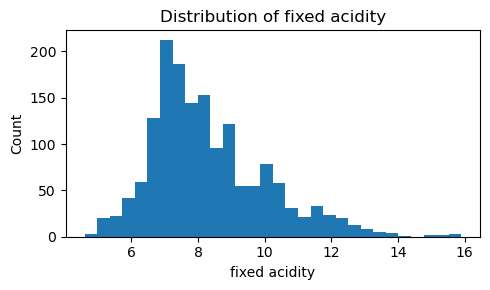

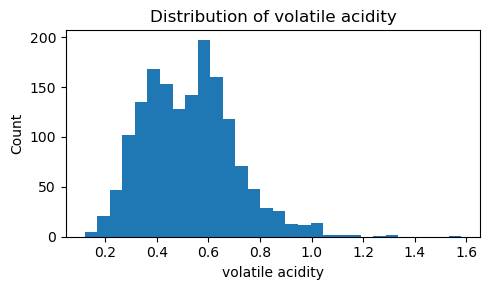

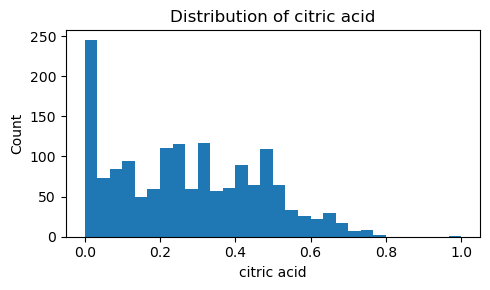

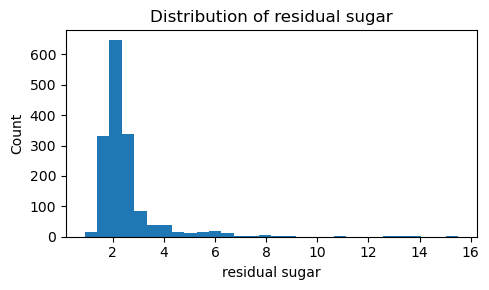

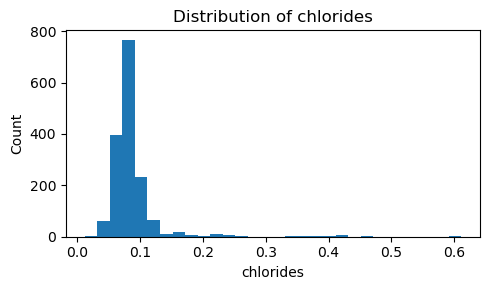

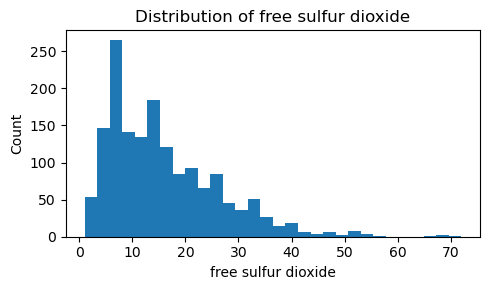

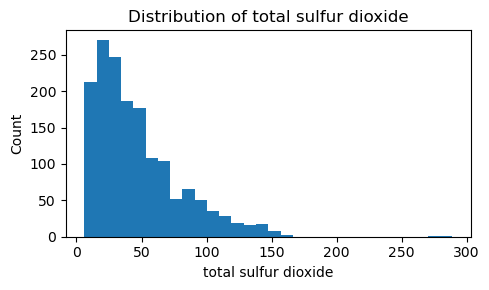

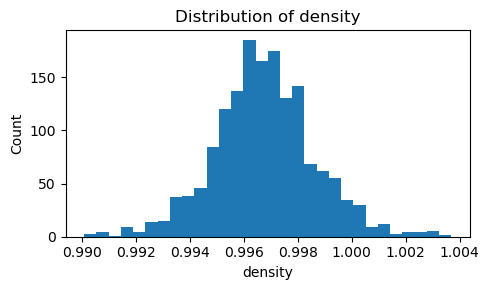

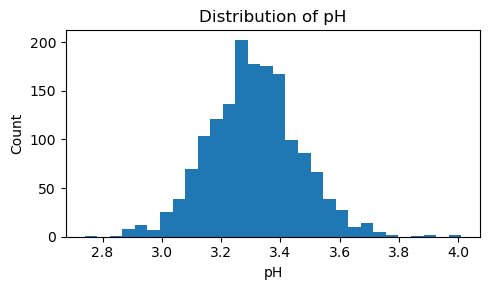

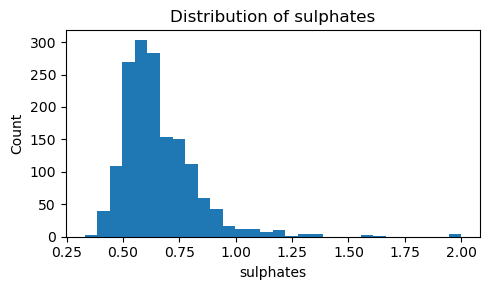

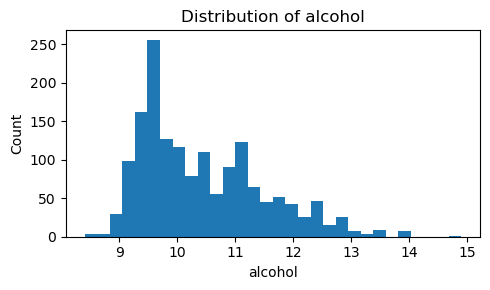

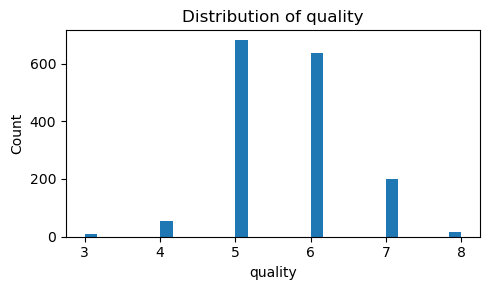

In [4]:
for i, col in enumerate(columns):
    plt.figure(figsize=(5, 3))
    plt.hist(data[:, i], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

4. 각 변수의 최소값-최대값(스케일 차이) 시각화

* Min-Max Scaling: 0~1 범위로 압축
* Z-score Standardization: 평균 0, 표준편차 1로 변환

In [5]:
mins = data.min(axis=0)
maxs = data.max(axis=0)

print("=== Feature Min–Max Table ===")
for col, mn, mx in zip(columns, mins, maxs):
    print(f"{col:25}  Min: {mn:8.4f}   Max: {mx:8.4f}")

=== Feature Min–Max Table ===
fixed acidity              Min:   4.6000   Max:  15.9000
volatile acidity           Min:   0.1200   Max:   1.5800
citric acid                Min:   0.0000   Max:   1.0000
residual sugar             Min:   0.9000   Max:  15.5000
chlorides                  Min:   0.0120   Max:   0.6110
free sulfur dioxide        Min:   1.0000   Max:  72.0000
total sulfur dioxide       Min:   6.0000   Max: 289.0000
density                    Min:   0.9901   Max:   1.0037
pH                         Min:   2.7400   Max:   4.0100
sulphates                  Min:   0.3300   Max:   2.0000
alcohol                    Min:   8.4000   Max:  14.9000
quality                    Min:   3.0000   Max:   8.0000
